# DGI Portfolio Builder

This notebook demonstrates the full pipeline of the DGI toolkit: loading fundamentals, screening, scoring, building a portfolio, plotting weights, and printing summary statistics.

In [1]:
import sys
print(f'Python version: {sys.version}')
import os
print('Current working directory:', os.getcwd())

Python version: 3.13.1 (main, Dec  3 2024, 17:59:52) [Clang 16.0.0 (clang-1600.0.26.4)]
Current working directory: /Users/rubendominguezfalcon/learning/AI Automation/dgi/dgi-toolkit/notebooks


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from dgi.screener import Screener
from dgi.validation import DgiRowValidator
from dgi.repositories.csv import CsvCompanyDataRepository
from dgi.scoring import DefaultScoring
from dgi.filtering import DefaultFilter
from dgi.portfolio import build, summary_stats

## Load Raw Fundamentals Data

In [3]:
csv_path = '../data/fundamentals_small.csv'
repo = CsvCompanyDataRepository(csv_path, DgiRowValidator())
screener = Screener(repo, scoring_strategy=DefaultScoring(), filter_strategy=DefaultFilter())
df = screener.load_universe()
df.head()

,symbol,name,sector,industry,dividend_yield,payout,dividend_cagr,fcf_yield
0,AAPL,Apple Inc.,Technology,Consumer Electronics,0.6,15.0,8.5,5.2
1,MSFT,Microsoft Corp.,Technology,Software,0.8,35.0,10.0,7.0
2,GOOG,Alphabet Inc.,Technology,Internet,0.7,25.0,12.0,6.5
3,JNJ,Johnson & Johnson,Healthcare,Pharmaceuticals,2.5,50.0,6.0,4.0
4,PG,Procter & Gamble,Consumer Staples,Household Products,1.2,55.0,5.5,3.8


## Apply Filters

In [4]:
filtered = screener.apply_filters(df, min_yield=0.5, max_payout=60, min_cagr=5.0)
filtered.head()

,symbol,name,sector,industry,dividend_yield,payout,dividend_cagr,fcf_yield
0,AAPL,Apple Inc.,Technology,Consumer Electronics,0.6,15.0,8.5,5.2
1,MSFT,Microsoft Corp.,Technology,Software,0.8,35.0,10.0,7.0
2,GOOG,Alphabet Inc.,Technology,Internet,0.7,25.0,12.0,6.5
3,JNJ,Johnson & Johnson,Healthcare,Pharmaceuticals,2.5,50.0,6.0,4.0
4,PG,Procter & Gamble,Consumer Staples,Household Products,1.2,55.0,5.5,3.8


## Score and Rank

In [5]:
scored = screener.add_scores(filtered)
scored = scored.sort_values('score', ascending=False)
scored.head()

,symbol,name,sector,industry,dividend_yield,payout,dividend_cagr,fcf_yield,score
2,GOOG,Alphabet Inc.,Technology,Internet,0.7,25.0,12.0,6.5,0.225000
0,AAPL,Apple Inc.,Technology,Consumer Electronics,0.6,15.0,8.5,5.2,0.178333
1,MSFT,Microsoft Corp.,Technology,Software,0.8,35.0,10.0,7.0,0.166667
3,JNJ,Johnson & Johnson,Healthcare,Pharmaceuticals,2.5,50.0,6.0,4.0,0.000000
4,PG,Procter & Gamble,Consumer Staples,Household Products,1.2,55.0,5.5,3.8,0.000000


## Build Portfolio (Top N, Equal Weight)

In [6]:
top_n = 5
portfolio = build(scored, top_n=top_n, weighting='equal')
portfolio.head()

,ticker,weight,score
2,GOOG,0.2,0.225000
0,AAPL,0.2,0.178333
1,MSFT,0.2,0.166667
3,JNJ,0.2,0.000000
4,PG,0.2,0.000000


## Plot Portfolio Weights

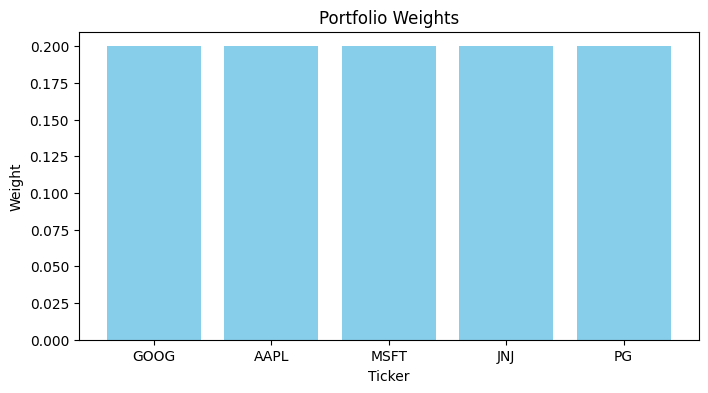

In [7]:
plt.figure(figsize=(8, 4))
plt.bar(portfolio['ticker'], portfolio['weight'], color='skyblue')
plt.xlabel('Ticker')
plt.ylabel('Weight')
plt.title('Portfolio Weights')
plt.show()

## Portfolio Summary Statistics

In [8]:
# Merge to get stats columns
merged = portfolio.merge(scored, left_on='ticker', right_on='symbol', how='left')
stats = summary_stats(merged)
print('Portfolio Yield:', stats['yield'])
print('Median CAGR:', stats['median_cagr'])
print('Mean Payout:', stats['mean_payout'])

Portfolio Yield: 1.16
Median CAGR: 8.5
Mean Payout: 36.0
